In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 17:45:41 2020

@author: mahyarfazlyab
"""

# import sys
# sys.path.append("../Python/")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
import scipy.io
import os
import pickle
import matplotlib.pyplot as plt
from NeuralNetwork import NeuralNetwork



def export2matlab(file_name, net, A, B, save_model=False):
    '''
    Export pytorch fully connected network to matlab

    '''

    num_layers = int((len(net) - 1) / 2)
    dim_in = float(net[0].weight.shape[1])
    dim_out = float(net[-1].weight.shape[0])
    hidden_dims = [float(net[2 * i].weight.shape[0]) for i in range(0, num_layers)]

    # network dimensions
    dims = [dim_in] + hidden_dims + [dim_out]

    # get weights
    # weights = np.zeros((num_layers+1,))
    weights = [net[2 * i].weight.detach().numpy().astype(np.float64) for i in range(0, num_layers + 1)]

    # get biases
    # biases = np.zeros((num_layers+1,))
    biases = [net[2 * i].bias.detach().numpy().astype(np.float64).reshape(-1, 1) for i in range(0, num_layers + 1)]

    activation = str(net[1])[0:-2].lower()

    # export network data to matlab
    data = {}
    data['net'] = {'weights': weights, 'biases': biases, 'dims': dims, 'activation': activation, 'name': file_name}
    data['AMatrix'] = A
    data['BMatrix'] = B

    scipy.io.savemat(file_name + '.mat', data)





`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [ ]:

trainCompleteLoop = True
# with open('xs.pkl', 'rb') as f:
#     Xtrain = pickle.load(f)
#
# with open('us.pkl', 'rb') as f:
#     Ytrain = pickle.load(f)

data = loadmat("trainDataQuad.mat")
Xtrain = data['X']
Ytrain = data['y']
# data = loadmat("quadRotorTrainData.mat")
# Xtrain = data['Xtrain']
# Ytrain = data['Ytrain']
# A = data['A']
# B = data['B']
if True:
    A = np.zeros((6, 6))
    A[0, 3] = 1
    A[1, 4] = 1
    A[2, 5] = 1

    B = np.zeros((6, 3))
    B[3, 0] =  9.8
    B[4, 1] = -9.8
    B[5, 2] =  1

    C = np.zeros((6, 1))
    C[5] = -9.8

    A = np.eye(6) + A * 0.1
    B = B * 0.1
    C = C * 0.1

else:
    A = np.array([[1, 1], [0, 1]])
    B = np.array([[0.5], [1]])
lastDim = 3
if trainCompleteLoop:
    Ytrain = (A @ Xtrain.T + B @ Ytrain.T + C).T
    lastDim = 6

# print(torch.linalg.norm(torch.Tensor(B)), torch.linalg.norm(torch.Tensor(A)))
# raise
# print(A)
# print(B)
# print(Xtrain.shape)
# print(Ytrain.shape)
trainset = torch.utils.data.TensorDataset(torch.Tensor(Xtrain), torch.Tensor(Ytrain))


net = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, lastDim))

train_batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=2)
epoch = 2000
net.train()
losses = []

def my_loss(output, target):
    gamma = 0.2
    loss = torch.mean((output - target)**2) \
           # + gamma * torch.linalg.norm(net[-1].weight) \
           #                                      * torch.linalg.norm(net[-3].weight) \
           #                                      * torch.linalg.norm(net[-5].weight)
    return loss
bestStateDic = None
bestLoss = 100000
criterion = my_loss
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for t in range(epoch):
    for i, (X, Y) in enumerate(trainloader):
        out = net(X)
        loss = criterion(out, Y)


        loss.backward()
        optimizer.step()

        with torch.no_grad():
            optimizer.zero_grad()
            for i in [0, 2, 4]:
                net[i].weight /= torch.maximum(torch.tensor([1]), (torch.linalg.norm(net[i].weight) / 1.))

            if loss < bestLoss:
                bestLoss = loss
                bestStateDic = net.state_dict()
    scheduler.step()



    losses.append(loss.item())
    if (np.mod(t, 10) == 0):
        print('epoch: ', t, 'MSE loss: ', loss.item())
        print(torch.linalg.norm(net[0].weight) * torch.linalg.norm(net[2].weight) * torch.linalg.norm(net[4].weight))




epoch:  0 MSE loss:  3.3264613151550293
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  10 MSE loss:  3.0668301582336426
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  20 MSE loss:  3.0031557083129883
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  30 MSE loss:  2.754281759262085
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  40 MSE loss:  2.663555383682251
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  50 MSE loss:  2.5010974407196045
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  60 MSE loss:  2.8811023235321045
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  70 MSE loss:  2.7055563926696777
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  80 MSE loss:  3.2778189182281494
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  90 MSE loss:  2.5856032371520996
tensor(1.0000, grad_fn=<MulBackward0>)
epoch:  100 MSE loss:  2.9646337032318115
tensor(1., grad_fn=<MulBackward0>)
epoch:  110 MSE loss:  2.6435062885284424
tensor(1., grad_fn=<MulBackward0>)
epoch:  120 MSE loss:  2.8176496028900146
tensor(

In [ ]:
layers = []
dimensions = [6, 32, 32, lastDim]
for i in range(len(dimensions) - 1):
    layers.append(nn.Linear(dimensions[i], dimensions[i + 1]))
    if i < len(dimensions) - 2:
        layers.append(nn.ReLU())
network = nn.Sequential(*layers)
networkClass = NeuralNetwork("../randomNetwork.pth")

networkClass.Linear = network
torch.save(networkClass.state_dict(), "../quadRotorCompleteLoopVq.0.pth")

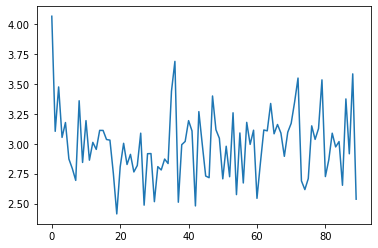

In [21]:
plt.plot(losses)

In [13]:
data = loadmat("trainDataQuad.mat")
Xtrain = data['X']
Ytrain = data['y']
Xtrain.shape

(11457, 6)